# ProphetDAG demo

This notebook contains a simple demo of `ProphetDAG`. `ProphetDAG` helps you use Prophet for forecasting multiple variables at once - especially when you want to use the output of one forecast as a regressor column in another.

Data set is daily Wikipedia pageviews for each page in the "Signers of the US constitution" category. Data from https://pageviews.toolforge.org/massviews/?project=en.wikipedia.org

For this demo, we will forecast the total number of daily pageviews

In [1]:
import pandas as pd
raw = pd.read_csv("constitution-signatories-views.csv")
raw.head()

,Title,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2020-10-04,2020-10-05,2020-10-06,2020-10-07,2020-10-08,2020-10-09,2020-10-10,2020-10-11,2020-10-12,2020-10-13
0,Alexander Hamilton,4217,4218,4700,8999,7650,5187,4446,4815,5056,...,24151,18804,16400,17237,16606,18459,24045,26973,21599,19323
1,George Washington,9553,9766,11329,25459,21185,12457,10971,10665,9247,...,15012,16245,15998,16238,18156,16664,14343,15955,16133,16315
2,Benjamin Franklin,10661,7308,7872,17024,13423,8802,8114,7259,8210,...,7231,8830,8943,9037,8864,8430,7167,7379,8569,8991
3,James Madison,2408,2971,4644,5789,5385,3234,2654,2493,2336,...,4732,5036,5343,4853,5311,5137,4457,4657,5197,5537
4,Roger Sherman,252,4601,3414,1385,872,452,307,268,255,...,294,356,403,423,335,349,246,243,360,447


Irritatingly this has the pages as rows and the dates as columns

In [2]:
transposed = raw.transpose(copy=True)
transposed.columns = transposed.iloc[0]
transposed = transposed.drop(['Title'], axis=0)
transposed

Title,Alexander Hamilton,George Washington,Benjamin Franklin,James Madison,Roger Sherman,Robert Morris (financier),John Dickinson,John Rutledge,Gouverneur Morris,Rufus King,...,Daniel of St. Thomas Jenifer,"George Read (American politician, born 1733)",Richard Dobbs Spaight,Thomas Fitzsimons,William Jackson (secretary),Jacob Broom,David Brearley,Gunning Bedford Jr.,Richard Bassett (Delaware politician),Template:United States Constitution signatories
2015-07-01,4217,9553,10661,2408,252,269,12,297,128,115,...,27,0,25,21,16,20,16,0,0,3
2015-07-02,4218,9766,7308,2971,4601,260,9,255,778,110,...,19,0,16,21,22,15,12,0,0,0
2015-07-03,4700,11329,7872,4644,3414,327,8,273,955,101,...,30,0,17,36,16,17,14,0,0,3
2015-07-04,8999,25459,17024,5789,1385,776,138,838,460,168,...,45,0,40,42,22,45,25,0,0,2
2015-07-05,7650,21185,13423,5385,872,561,61,595,317,128,...,33,0,49,36,21,42,19,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-09,18459,16664,8430,5137,349,298,362,453,253,191,...,27,27,22,29,27,18,19,26,16,0
2020-10-10,24045,14343,7167,4457,246,210,269,293,205,159,...,19,26,16,19,19,10,6,11,12,0
2020-10-11,26973,15955,7379,4657,243,245,282,357,220,179,...,19,27,16,14,15,19,11,22,19,1
2020-10-12,21599,16133,8569,5197,360,290,349,668,285,217,...,32,33,14,29,18,10,25,27,26,0


There are 41 pages in the category but some of them are much more important that others

In [3]:
totals = pd.DataFrame({"pageviews":transposed.sum()})
totals = totals.sort_values(by="pageviews",ascending=False)
totals['cumulative'] = totals["pageviews"].cumsum()
totals['cumulative_percentage'] = totals['cumulative']/totals['cumulative'].max()
totals.head()

,pageviews,cumulative,cumulative_percentage
Title,,,
Alexander Hamilton,39166341.0,39166341.0,0.409897
George Washington,26307376.0,65473717.0,0.685219
Benjamin Franklin,16522462.0,81996179.0,0.858135
James Madison,7623497.0,89619676.0,0.937919
Roger Sherman,656498.0,90276174.0,0.944790


We can cover >85% of the total with just three people.

The big idea here is to build excellent individual forecast for those three - using specific events (like the launch of "Hamilton" the movie on Disney+) to make those forecasts as good as we can.

Then we want to use the results of those three forecasts as input into our forecast of the total. When Benjamin Franklin is forecasted to have an increased number of pageviews this should increase the total too.

Just adding the point estimate from those three forecasts as regressors in the forecast of the total can work well but uncertainties in the forecasted values won't be included then. The `ProphetDAG` class methods build the correct model for this to happen.

First filter out the data we need:

In [4]:
transposed['total'] = transposed.sum(axis=1)
df = transposed[['Alexander Hamilton','George Washington','Benjamin Franklin','total']]
df = df.reset_index()
df = df.rename(columns={"index":"ds"})

And import the necessary modules

In [5]:
from prophetDAG import ProphetDAG
import networkx as nx
from fbprophet import Prophet

For `ProphetDAG` to work we need to describe the "graph" of dependencies between our variables.

In this case it is fairly simple:
1. Assume each of the signatories is independent of the others
2. The total pageviews is dependent on all of them

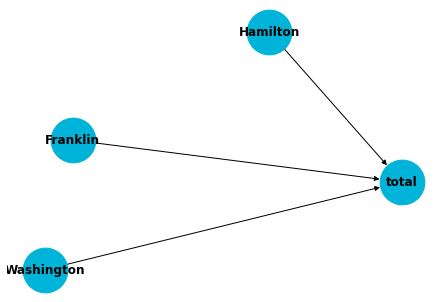

In [6]:
graph = nx.DiGraph()
graph.add_nodes_from([(1,{'name':'total'})
                     ,(2,{'name':'Hamilton'})
                     ,(3,{'name':'Washington'})
                     ,(4,{'name':'Franklin'})])
graph.add_edge(2,1)
graph.add_edge(3,1)
graph.add_edge(4,1)
labels = nx.get_node_attributes(graph, 'name') 
nx.draw(graph, labels=labels, node_color='#00b4d9', font_weight='bold', node_size=2000)

Next we must prepare the graph by adding data and a prophet model to each node.

This is where you could get clever with adding extra regressors and seasonalities that would be specific for each signatory. But for this example we will keep it simple and just add US holidays and nothing else.

In [7]:
history_dates = pd.to_datetime(pd.Series(df['ds'].unique(), name='ds')).sort_values()
df['ds'] = pd.to_datetime(df['ds'])
start = df['ds'].min()
t_scale = df['ds'].max() - start
total = df[['ds','total']].rename(columns={"total":"y"})
hamilton = df[['ds','Alexander Hamilton']].rename(columns={"Alexander Hamilton":"y"})
washington = df[['ds','George Washington']].rename(columns={"George Washington":"y"})
franklin = df[['ds','Benjamin Franklin']].rename(columns={"Benjamin Franklin":"y"})

for (i,d) in zip(graph.nodes,[total,hamilton,washington,franklin]):
    graph.nodes[i]['df'] = d
    m = Prophet()
    m.add_country_holidays(country_name="US")
    m.history_dates = history_dates
    m.start = start
    m.t_scale = t_scale
    future = m.make_future_dataframe(periods=365)
    graph.nodes[i]['prophet'] = m
    graph.nodes[i]['future'] = future


Now the graph is ready to be fitted. This can take a long time...

In [8]:
p = ProphetDAG()
result = p.fit(graph)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_212810f865f60699dfc689ee4c288d14 NOW.


The estimated forecast values for each node are in the `y_hat` attribute.

You can also get 1000 samples for figuring out predictive intervals and the like from the `y_samples` key.

In [9]:
graph.nodes[1]['y_hat']

array([104819.6502175 , 106554.30999696, 103974.5640673 , 106512.93026692,
       111319.43028808, 115565.8098059 , 116123.94638747, 114868.13771192,
       116835.07060756, 114296.62513599, 116682.23537505, 121144.600436  ,
       124863.83181433, 124725.61390131, 122623.07783399, 123616.20192809,
       120003.91035793, 121245.61333339, 124526.00740935, 127058.24986535,
       125761.11371168, 122559.85421669, 122544.63097171, 118041.68705239,
       118534.05663634, 121225.64518682, 123343.81820567, 121816.1231013 ,
       121079.33441604, 118695.5528801 , 114507.92856597, 115477.1677434 ,
       118788.26934415, 121645.24865772, 120948.57726642, 118596.61588929,
       119644.86734899, 116378.2263554 , 118232.96528343, 122362.2615201 ,
       125940.35865405, 125840.93844357, 123939.39776596, 115473.42745436,
       122112.87840029, 123888.1421881 , 127749.99385591, 130876.8244817 ,
       130152.33058318, 127467.52536316, 127880.28498417, 123687.59663421,
       124347.24649541, 1